# Smart Mobility Challenge for a Greener Future

## Introduction
This Jupyter Notebook presents the work of the **Adorable Interns** team and completes the document *Method.pdf*. It is structured in three sections as following:
- **1. Data analysis**,
- **2. Benchmark phase**,
- **3. Submitted model**.

Though one can reproduce our submission by executing the third section, it is quicker to execute the file **main.py**. Catboost package being deterministic on CPU, it does not require to specify a seed. For this challenge, we used an AMD Ryzen 9 5900X 12-Core Processor. Training a catboost model takes approximately 10 minutes. 

## Context
A detailled presentation of the challenge can be found in the document *Method.pdf*. The goal of the challenge is to forecast the states of 91 electric vehicle charging stations in Paris, each station containing 3 plugs. The possible states of a plug are *Available*, *Charging*, *Passive*, and *Other*. We measure the state of each plug every 15 minutes. We want to make predictions at 3 levels of spatial granularity:
- the station level,
- the area level (*North*, *South*, *East*, and *West*),
- the global level.

We have at hand data from 2020-07-03 to 2021-02-18. We want to forecast the states of the stations from 2021-02-19 to 2021-03-10.

## General imports

We first need to import some necessary functions and packages and to instantiate a few variables. Make sure the packages listed in the **requirements.txt** file are installed.

In [1]:
from src.models.catboost_model import Catboost_Model
from src.models.mean import Mean
from src.models.median import Median
from src.submission import output_submission
from src.generate_data import import_data, format_data, generate_area_and_global, split_dataset, remove_target_columns
from src.score import overall_score

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os

pd.options.mode.chained_assignment = None 
DATA_DIR = os.path.abspath('data')

#Define the targets to forecast and the features to train the models on.
targets = ["Available", "Charging", "Passive", "Other"]
station_features = ['Station', 'tod', 'dow', 'area', 'trend', 'Latitude', 'Longitude']  
area_features = ['area', 'tod', 'dow', 'trend', 'Latitude', 'Longitude']  
global_features = ['tod', 'dow', 'trend'] 

#Import the training data, format it and aggregate it into the area and global levels.
train_station_raw = import_data("train", DATA_DIR)
train_station = format_data(train_station_raw)
train_area, train_global = generate_area_and_global(train_station)

## 1. Data analysis

### 1.1 Missing values and change in the data distribution

We start by remarking that the data presents a lot of missing values, spread in almost half of the training data period. Moreover, the data distribution changes after 2020-10-22. Before this date, missing values are rare and after this event, they become common. Knowing more about this event will help us construct effective models.

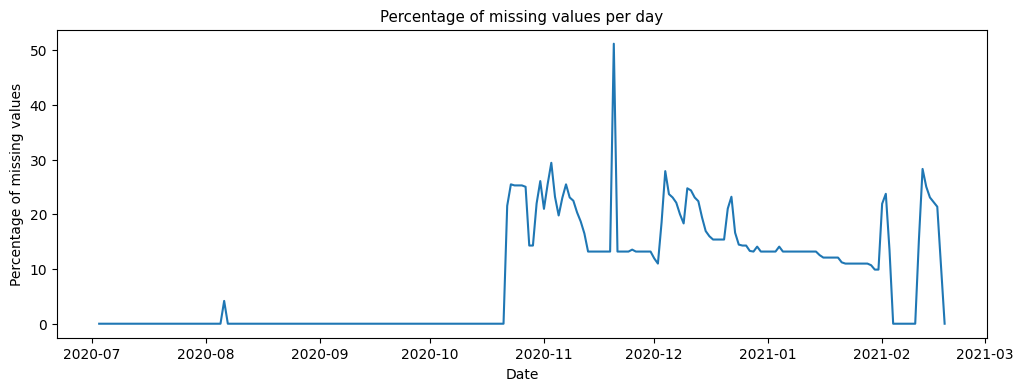

In [2]:
daily_data = train_station.groupby([pd.Grouper(key='date',freq='D')]).agg({'Available':'sum','Charging':'sum','Passive':'sum', 'Other':'sum'}).reset_index()
daily_data["Total"] = daily_data[targets].sum(1)

plt.figure(figsize=(12, 4))
percentage_missing_values = pd.DataFrame()
percentage_missing_values["Total"] = 100*(1 - daily_data["Total"]/91/3/96)
plt.plot(daily_data["date"], percentage_missing_values)
plt.rcParams['font.size'] = 9
plt.ylabel("Percentage of missing values")
plt.xlabel("Date")
plt.title("Percentage of missing values per day")
plt.show()

In [3]:
percentage_missing_values["date"] = daily_data["date"]
day_change = percentage_missing_values[percentage_missing_values["Total"] > 10]
print(f"The data distribution changes on {day_change['date'].min()}.")

The data distribution changes on 2020-10-22 00:00:00.


### 1.2 Missing values are spread among all stations

Here, we are interested in the distribution of the missing values on the day of the change in the data distribution. We see that most of the stations (80%) are impacted, but some more than others.

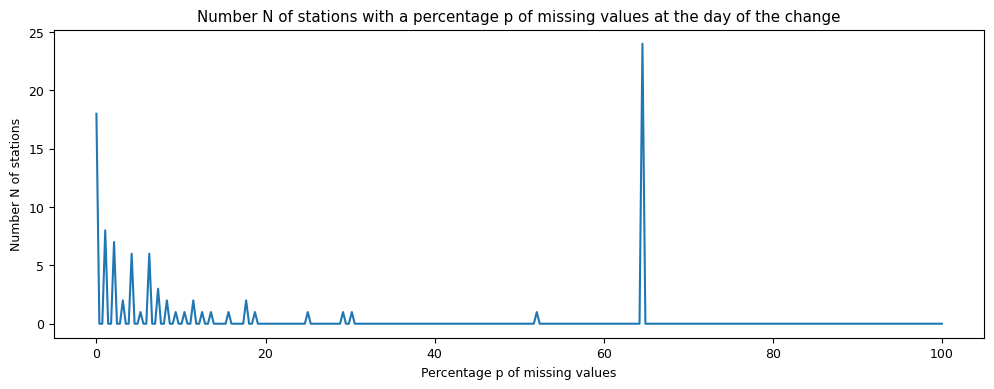

In [4]:
station_daily_data = train_station.groupby([pd.Grouper(key='date',freq='D'),'Station']).agg({'Available':'sum','Charging':'sum','Passive':'sum', 'Other':'sum'}).reset_index()
station_daily_data["Total"] = station_daily_data[['Available', 'Charging', 'Passive', 'Other']].sum(1)
number_of_stations_with_i_missing_values = []
for i in range(289):
    stations_with_missing_values = station_daily_data[(station_daily_data["date"]=="2020-10-22") & (288-station_daily_data["Total"] == i)]["Station"].values
    number_of_stations_with_i_missing_values.append(len(stations_with_missing_values))

plt.figure(figsize=(12, 4))
plt.plot([i/288*100 for i in range(289)], number_of_stations_with_i_missing_values)
plt.rcParams['font.size'] = 9
plt.ylabel("Number N of stations")
plt.xlabel("Percentage p of missing values")
plt.title("Number N of stations with a percentage p of missing values at the day of the change")
plt.show()

In [5]:
print("At the day of the change in the data distribution", int((1-number_of_stations_with_i_missing_values[0]/91)*100),"% of the stations present missing values.")

At the day of the change in the data distribution 80 % of the stations present missing values.


### 1.3 Stations with the most missing values have a specific behavior

At the time of the change, we can distinguish two regimes of stations. Some of them present a low percentage of missing values, while a surprisingly high number of stations (24 out of 91) present more than 60 % of missing values. Therefore, we consider these stations as being outliers. Our hypothesis is that these stations were already not working properly before the change and an update in the station monitoring software revealed their malfunctioning on 2020-10-22. We test this hypothesis by looking at the stations stuck in a state without car, i.e. Passive or Other, during a full week before the change. Note that this test is very restrictive since we are looking at the stations which present exactly the same state for each 15-minute step during the whole 7 days preceding the change in the data distribution.

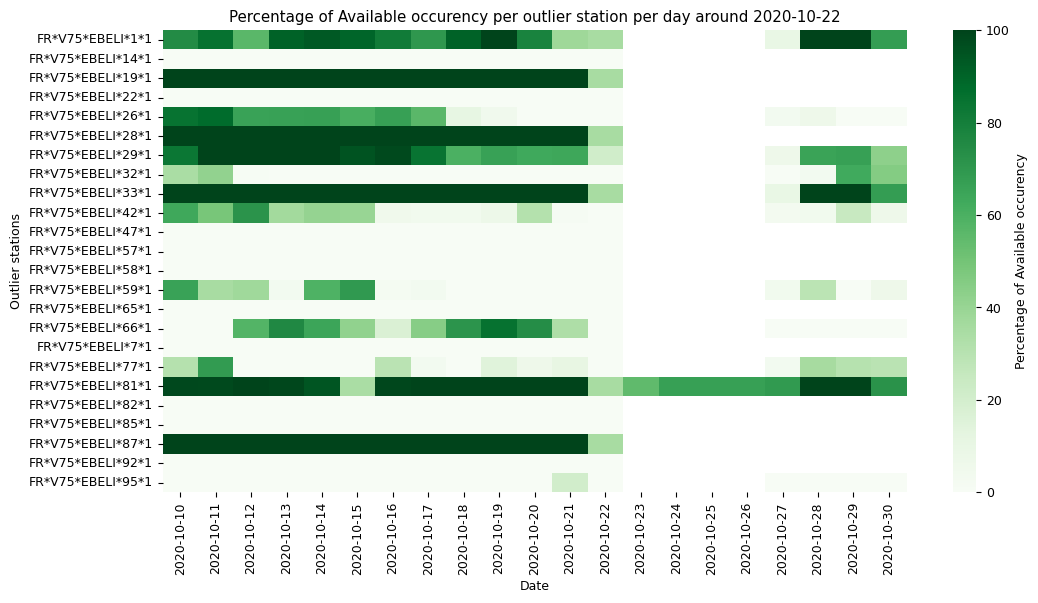

In [6]:
outliers = station_daily_data[(station_daily_data["Total"]==288-186) & (station_daily_data["date"]=="2020-10-22")]["Station"]
outliers_data = station_daily_data[station_daily_data["Station"].isin(outliers) & (station_daily_data["date"]>="2020-10-10") & (station_daily_data["date"]<="2020-10-30")]
outliers_data['date'] = outliers_data['date'].dt.strftime("%Y-%m-%d")
outliers_data_available = outliers_data.pivot(index='Station', columns='date')['Available']

percentage_other = outliers_data_available/288*100
fig, ax = plt.subplots(figsize=(12, 6))
hm = sns.heatmap(percentage_other,cmap="Greens")
hm.set(xlabel='Date', ylabel='Outlier stations')
ax.set_title("Percentage of Available occurency per outlier station per day around 2020-10-22")
ax.collections[0].colorbar.set_label("Percentage of Available occurency")
plt.show()

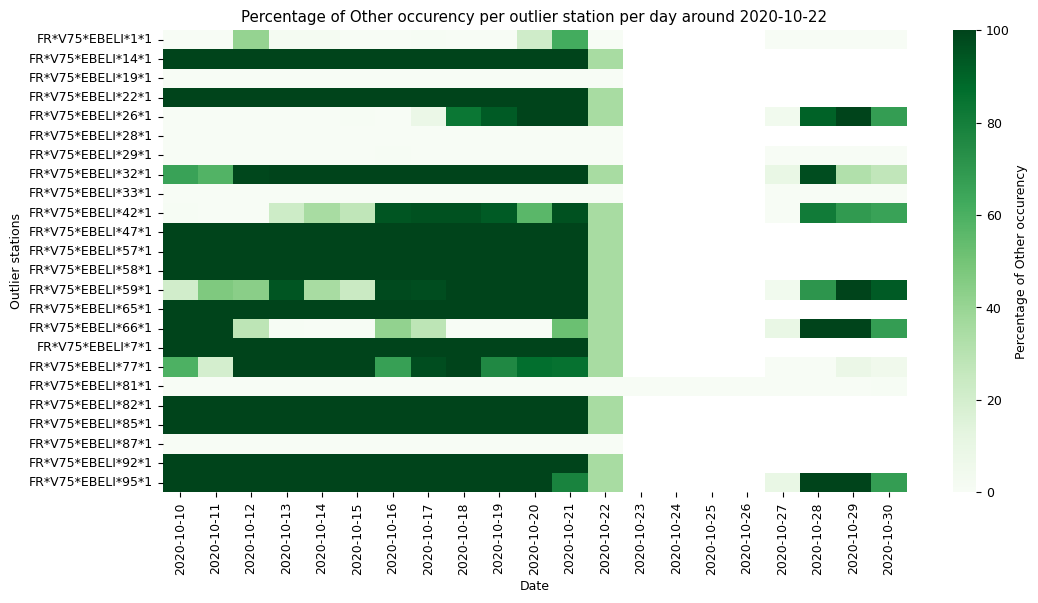

In [7]:
outliers_data_other = outliers_data.pivot(index='Station', columns='date')['Other']
outliers_data_other = outliers_data_other.copy()

percentage_other = outliers_data_other/288*100
fig, ax = plt.subplots(figsize=(12, 6))
hm = sns.heatmap(percentage_other,cmap="Greens")
hm.set(xlabel='Date', ylabel='Outlier stations')
ax.set_title("Percentage of Other occurency per outlier station per day around 2020-10-22")
ax.collections[0].colorbar.set_label("Percentage of Other occurency")
plt.show()

In the last two plots, we see that most of the outlier stations were stuck in either state *Available* or *Other*, which can be directly seen by the long dark green lines. At the time of the change in the data distribution, on 2020-10-22, the dark green lines stop and are replaced by missing values. Then, we derive a quantitative equivalent of these plots.

In [8]:
stations_stuck_before_break = station_daily_data[(station_daily_data["date"]>="2020-10-15") & (station_daily_data["date"]<="2020-10-21")].groupby("Station").agg({'Available':'sum','Charging':'sum','Passive':'sum', 'Other':'sum'}).reset_index()
stations_stuck_before_break = stations_stuck_before_break[((stations_stuck_before_break["Available"] == 288*7) | (stations_stuck_before_break["Other"] == 288*7))]["Station"].values

n_stuck = len(stations_stuck_before_break)
n_outlier_stuck = len(list(set(stations_stuck_before_break) & set(outliers)))
n_outlier = len(outliers)

print(f"{n_stuck} stations are stuck in either Available or Other during the week before 2020-10-22.")
print(f"{n_outlier_stuck}, ie {int(n_outlier_stuck/n_stuck*100)}%, of the stations stuck in either Available or Other during this week are outliers on 2020-10-22.")
print(f"{n_outlier_stuck}, ie {int(n_outlier_stuck/n_outlier*100)}%, of the outlier stations on 2020-10-22 are stuck in either Available or Other the week before 2020-10-22. ")

17 stations are stuck in either Available or Other during the week before 2020-10-22.
15, ie 88%, of the stations stuck in either Available or Other during this week are outliers on 2020-10-22.
15, ie 62%, of the outlier stations on 2020-10-22 are stuck in either Available or Other the week before 2020-10-22. 


These results confirm our hypothesis. The fact of being stuck in a car-less state is strongly correlated (88%) to the fact of presenting a high number of missing values at the time of the change in the data distribution. Moreover, this phenomenon accounts for most (62%) of the outlier stations and seems to explain it well.

### 1.4 Trend and stationnarity of the distribution

As explained in *Method.pdf*, we expect the data to present a yearly seasonal effect and a trend. We do not have enough data to distinguish the two phenomena. However, the following plot at least shows that the data distribution depends on the time.

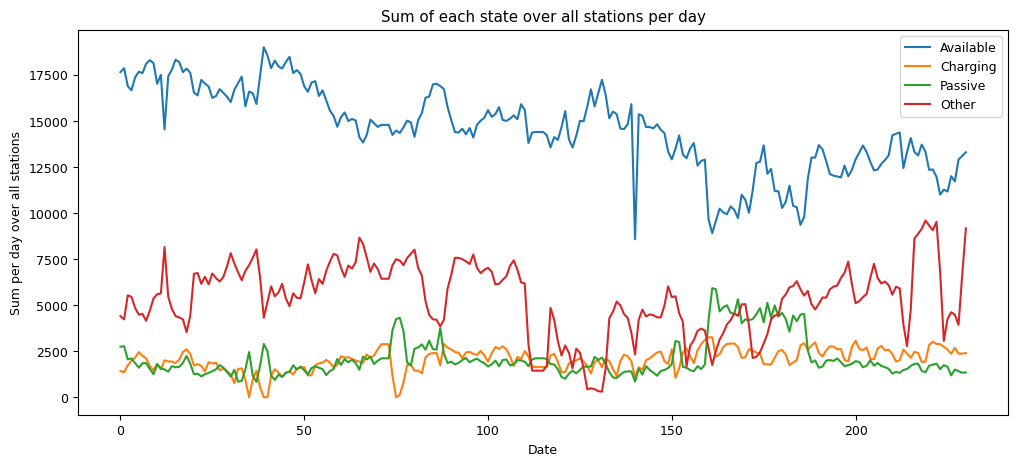

In [9]:
plt.figure(figsize=(12, 5))
for state in targets :
    plt.plot(daily_data.index, daily_data[state])
plt.rcParams['font.size'] = 9
plt.ylabel("Sum per day over all stations")
plt.xlabel("Date")
plt.legend(targets)
plt.title("Sum of each state over all stations per day")
plt.show()

## 2. Benchmark phase

The goal of this section is to test the different models presented in part **2- Algorithm and Method** of the file *Method.pdf*. We train these model on the 95 first percents of the data and we validate them on the last 5 percents. All along this section, **BCM** stands for benchmark and **val** for validation.

In [10]:
# Split training dataset to create a validation dataset.
train_station_bcm, val_station_bcm = split_dataset(train_station, threshold=0.95) 
train_area_bcm, val_area_bcm = split_dataset(train_area, threshold=0.95) 
train_global_bcm, val_global_bcm = split_dataset(train_global, threshold=0.95) 

# Use last 20% of training datasets for early stopping of catboost model.
train_station_bcm, early_stop_station_bcm = split_dataset(train_station_bcm, threshold=0.8, keep_initial_dataset=True)
train_area_bcm, early_stop_area_bcm = split_dataset(train_area_bcm, threshold=0.8, keep_initial_dataset=True)
train_global_bcm, early_stop_global_bcm = split_dataset(train_global_bcm, threshold=0.8, keep_initial_dataset=True)

# Remove target columns from validation datasets to make predictions on them.
val_station_bcm_filtered = remove_target_columns(val_station_bcm, targets)
val_area_bcm_filtered = remove_target_columns(val_area_bcm, targets)
val_global_bcm_filtered = remove_target_columns(val_global_bcm, targets)

### 2.1 Mean model

We start with a mean model that predicts the target by averaging the training data given the features $(tod, dow)$.

In [11]:
# Instantiate the models.
model_station = Mean(train_station_bcm, type="station")
model_area = Mean(train_area_bcm, type="area")
model_global = Mean(train_global_bcm, type="global")

# Train the models.
model_station.train()
model_area.train()
model_global.train()

# Make predictions.
prediction_station = model_station.predict(val_station_bcm_filtered)
prediction_area = model_area.predict(val_area_bcm_filtered)
prediction_global = model_global.predict(val_global_bcm_filtered)

# Compute the score on the validation dataset.
score = overall_score(val_station_bcm, val_area_bcm, val_global_bcm, 
                      prediction_station, prediction_area, prediction_global)
                        
print("The score for the mean model is: " + str(score))

The score for the mean model is: 315.99186256781195


### 2.2 Median model

The second model is very similar. We replace the mean estimator by the median.

In [12]:
# Instantiate the models.
model_station = Median(train_station_bcm, type="station")
model_area = Median(train_area_bcm, type="area")
model_global = Median(train_global_bcm, type="global")

# Train the models.
model_station.train()
model_area.train()
model_global.train()

# Make predictions.
prediction_station = model_station.predict(val_station_bcm_filtered)
prediction_area = model_area.predict(val_area_bcm_filtered)
prediction_global = model_global.predict(val_global_bcm_filtered)

# Compute the score on the validation dataset.
score = overall_score(val_station_bcm, val_area_bcm, val_global_bcm, 
                      prediction_station, prediction_area, prediction_global)
                        
print("The score for the median model is: " + str(score))

The score for the median model is: 309.0660036166365


### 2.3 Catboost model C(4,150)

The mean and median models handle well missing values and take advantage of the fact that malfunctioning stations tend to stay in specific states. However, they do not take advantage of the spatial distribution of the stations, contrary to the following catboost model. The Catboost model is a tree-based gradient boosting algorithm specialised in categorical regression. Here, the models is composed of 12 functions: one per state and per granularity. For example, one of the regressors is an estimator $u$ of the state $y_{t, k}$ of station $k$ at time $t$ and we write

![title](src/assets/y.png)

Let $z_t$ be the general states of all stations, all areas and the global level at time $t$. We want to find an estimator $\hat{z}$ optimizing the expected validation loss 

# ![title](src/assets/estimator.png)

An usual way to do so is to train the model with its discretized version as the empirical loss, i.e.

# ![title](src/assets/empirical_loss.png)

In [13]:
# Instantiate the models.
model_station = Catboost_Model(train_data=train_station_bcm,
                                early_stop=early_stop_station_bcm,
                                features=station_features,
                                cat_features=[0, 1, 2, 3],
                                targets=targets,
                                learning_rate=0.1,
                                iterations=150,
                                depth=4,
                                level_col="Station")

model_area = Catboost_Model(train_data=train_area_bcm,
                            early_stop=early_stop_area_bcm,
                            features=area_features,
                            cat_features=[0, 1, 2],
                            targets=targets,
                            learning_rate=0.1,
                            iterations=150,
                            depth=4,
                            level_col="area")

model_global = Catboost_Model(train_data=train_global_bcm,
                                early_stop=early_stop_global_bcm,
                                features=global_features,
                                cat_features=[0, 1],
                                targets=targets,
                                learning_rate=0.1,
                                iterations=150,
                                depth=4,
                                level_col="global")

# Train the models.
model_station.train()
model_area.train()
model_global.train()

# Make predictions.
prediction_station = model_station.predict(val_station_bcm_filtered)
prediction_area = model_area.predict(val_area_bcm_filtered)
prediction_global = model_global.predict(val_global_bcm_filtered)

==== Target  Available  ====
Iteration  1 / 4
0:	learn: 0.9256403	test: 0.9880191	best: 0.9880191 (0)	total: 360ms	remaining: 53.6s
50:	learn: 0.7451782	test: 0.8588736	best: 0.8588736 (50)	total: 10.6s	remaining: 20.5s
100:	learn: 0.7441010	test: 0.8586160	best: 0.8586160 (100)	total: 19.7s	remaining: 9.55s
149:	learn: 0.7345021	test: 0.8487012	best: 0.8487012 (149)	total: 28.7s	remaining: 0us

bestTest = 0.8487011901
bestIteration = 149

==== Target  Charging  ====
Iteration  2 / 4
0:	learn: 0.2512742	test: 0.3116702	best: 0.3116702 (0)	total: 402ms	remaining: 59.8s
50:	learn: 0.2507829	test: 0.3104512	best: 0.3104512 (50)	total: 18.6s	remaining: 36.1s
100:	learn: 0.2507829	test: 0.3104512	best: 0.3104512 (100)	total: 36.7s	remaining: 17.8s
149:	learn: 0.2507829	test: 0.3104512	best: 0.3104512 (149)	total: 54.4s	remaining: 0us

bestTest = 0.3104511577
bestIteration = 149

==== Target  Passive  ====
Iteration  3 / 4
0:	learn: 0.2661893	test: 0.3340896	best: 0.3340896 (0)	total: 416ms	

In [14]:
# Compute the score on the validation dataset.
score = overall_score(val_station_bcm, val_area_bcm, val_global_bcm, 
                      prediction_station, prediction_area, prediction_global)
                        
print("The score for the catboost model is: " + str(score))

The score for the catboost model is: 292.3146473779385


### 2.4 Catboost model with exponential loss Cexp(5,200)

Though the previous models handle well missing data, they can neither capture the trend/seasonality, nor the change in the data distribution. To this end, we train the catboost model with an exponentially decaying training loss

![title](src/assets/exponential_decaying.png)

with $\tau = 30$ days and tmax = 2021-02-19 00:00:00. It gives more weight to the data after the change in the data distribution and capture the last effect of the trend, while using as much data as possible.
After tuning hyperparameters, we found the model with $depth=5$ and $iterations = 200$ as being the best trade-off between performances and number of parameters.

In [15]:
# Instantiate the models with an exponential loss.
model_station = Catboost_Model(train_data=train_station_bcm,
                                early_stop=early_stop_station_bcm,
                                features=station_features,
                                cat_features=[0, 1, 2, 3],
                                targets=targets,
                                learning_rate=0.1,
                                iterations=200,
                                depth=5,
                                level_col="Station",
                                expo_loss=True)

model_area = Catboost_Model(train_data=train_area_bcm,
                            early_stop=early_stop_area_bcm,
                            features=area_features,
                            cat_features=[0, 1, 2],
                            targets=targets,
                            learning_rate=0.1,
                            iterations=200,
                            depth=5,
                            level_col="area",
                            expo_loss=True)

model_global = Catboost_Model(train_data=train_global_bcm,
                                early_stop=early_stop_global_bcm,
                                features=global_features,
                                cat_features=[0, 1],
                                targets=targets,
                                learning_rate=0.1,
                                iterations=200,
                                depth=5,
                                level_col="global",
                                expo_loss=True)

# Train the models.
model_station.train()
model_area.train()
model_global.train()

# Make predictions.
prediction_station = model_station.predict(val_station_bcm_filtered)
prediction_area = model_area.predict(val_area_bcm_filtered)
prediction_global = model_global.predict(val_global_bcm_filtered)

==== Target  Available  ====
Iteration  1 / 4
0:	learn: 1.5816644	test: 1.5356952	best: 1.5356952 (0)	total: 978ms	remaining: 3m 14s
50:	learn: 0.7478992	test: 0.7731891	best: 0.7731891 (50)	total: 34.8s	remaining: 1m 41s
100:	learn: 0.7113961	test: 0.7360103	best: 0.7360103 (100)	total: 1m 9s	remaining: 1m 8s
150:	learn: 0.6848362	test: 0.7045270	best: 0.7045270 (150)	total: 1m 44s	remaining: 33.9s
199:	learn: 0.6655965	test: 0.6793836	best: 0.6793836 (199)	total: 2m 18s	remaining: 0us

bestTest = 0.6793835718
bestIteration = 199

==== Target  Charging  ====
Iteration  2 / 4
0:	learn: 0.3183384	test: 0.3202803	best: 0.3202803 (0)	total: 852ms	remaining: 2m 49s
50:	learn: 0.3518469	test: 0.3540396	best: 0.3202803 (0)	total: 34.2s	remaining: 1m 39s
100:	learn: 0.3406250	test: 0.3408087	best: 0.3202803 (0)	total: 1m 7s	remaining: 1m 6s
150:	learn: 0.3362221	test: 0.3356090	best: 0.3202803 (0)	total: 1m 41s	remaining: 33.1s
199:	learn: 0.3336189	test: 0.3328393	best: 0.3202803 (0)	total: 

In [16]:
# Compute the score on the validation dataset.
score = overall_score(val_station_bcm, val_area_bcm, val_global_bcm, 
                      prediction_station, prediction_area, prediction_global)
                        
print("The score for the catboost model with exponential loss and fine tuned hypermarameters is: " + str(score))

The score for the catboost model with exponential loss and fine tuned hypermarameters is: 261.18173598553346


## 3. Submitted model

After benchmarking and sending our models to validation on a subset of the test data, we found that the best model was the $C_{exp}(5, 200)$. The following script trains this model on the whole training data and then generates the output files containing the predictions for the challenge testing data. These csv files are stored in the *output* folder.

In [17]:
# Split training dataset to create a testing dataset for catboost
train_station, early_stop_station = split_dataset(train_station, threshold=0.8, keep_initial_dataset=True)
train_area, early_stop_area = split_dataset(train_area, threshold=0.8, keep_initial_dataset=True)
train_global, early_stop_global = split_dataset(train_global, threshold=0.8, keep_initial_dataset=True)

# Instantiate the models
model_station = Catboost_Model(train_data=train_station,
                                early_stop=early_stop_station,
                                features=station_features,
                                cat_features=[0, 1, 2, 3],
                                targets=targets,
                                learning_rate=0.1,
                                iterations=200,
                                depth=5,
                                level_col="Station",
                                expo_loss=True)

model_area = Catboost_Model(train_data=train_area,
                            early_stop=early_stop_area,
                            features=area_features,
                            cat_features=[0, 1, 2],
                            targets=targets,
                            learning_rate=0.1,
                            iterations=200,
                            depth=5,
                            level_col="area",
                            expo_loss=True)

model_global = Catboost_Model(train_data=train_global,
                                early_stop=early_stop_global,
                                features=global_features,
                                cat_features=[0, 1],
                                targets=targets,
                                learning_rate=0.1,
                                iterations=200,
                                depth=5,
                                level_col="global",
                                expo_loss=True)

# Train the models
model_station.train()
model_area.train()
model_global.train()

# Import the testing dataset
test_station_raw = import_data("test", DATA_DIR)

# Format the test dataset columns to the expected types
test_station = format_data(test_station_raw)

# Generate area and global datasets from the testing data at station level
test_area, test_global = generate_area_and_global(test_station, is_test=True)

# Make predictions on testing dataset
prediction_station = model_station.predict(test_station)
prediction_area = model_area.predict(test_area)
prediction_global = model_global.predict(test_global)

# Generate the csv files containing the predictions
output_submission(prediction_station, prediction_area, prediction_global, targets)

print("Completed")

==== Target  Available  ====
Iteration  1 / 4
0:	learn: 1.5594891	test: 1.5395729	best: 1.5395729 (0)	total: 887ms	remaining: 2m 56s
50:	learn: 0.7285125	test: 0.7373205	best: 0.7373205 (50)	total: 36.5s	remaining: 1m 46s
100:	learn: 0.6921695	test: 0.6999832	best: 0.6999832 (100)	total: 1m 12s	remaining: 1m 11s
150:	learn: 0.6700153	test: 0.6729463	best: 0.6729463 (150)	total: 1m 49s	remaining: 35.4s
199:	learn: 0.6542719	test: 0.6553382	best: 0.6553382 (199)	total: 2m 24s	remaining: 0us

bestTest = 0.6553381946
bestIteration = 199

==== Target  Charging  ====
Iteration  2 / 4
0:	learn: 0.3268914	test: 0.3307613	best: 0.3307613 (0)	total: 894ms	remaining: 2m 57s
50:	learn: 0.3573846	test: 0.3566934	best: 0.3307613 (0)	total: 35.6s	remaining: 1m 43s
100:	learn: 0.3453414	test: 0.3434730	best: 0.3307613 (0)	total: 1m 11s	remaining: 1m 9s
150:	learn: 0.3405070	test: 0.3382166	best: 0.3307613 (0)	total: 1m 47s	remaining: 34.9s
199:	learn: 0.3365339	test: 0.3336583	best: 0.3307613 (0)	tota